In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [83]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## TODO: grab error scores for AE, Inpaint and Restore
> GradCAM?

In [135]:
error_scores = {}
for ds in ["abcd-val", "abcd-test", "abcd_lesion_load_20", "abcd_tumor"]:
    data = np.load(f"Results/20231004_insize96-112-80_z512_denseAE_sigmoid/{ds}/error_map.npz", allow_pickle=True)
    error_scores[ds] = data['error_maps']  
error_scores['abcd-val'].shape

(165, 96, 112, 80)

In [84]:
from sade.datasets.loaders import get_dataloaders
from sade.configs.flows import ve_flow_config as configs
config = configs.get_config()
config.data.dataset = "ABCD"
config.eval.experiment.train = "abcd-val"
config.eval.experiment.inlier = "abcd-test"
config.eval.experiment.ood = "lesion_load_20"
config.device = torch.device("cpu")

(val_ds, inlier_ds, ood_ds), _ = get_dataloaders(
    config, evaluation=True, ood_eval=True,
)

In [85]:
%%time
x_val = []
for x in val_ds:
    x_val.append(x["image"])
    
x_val = torch.cat(x_val)

CPU times: user 1.19 s, sys: 1.28 s, total: 2.48 s
Wall time: 19.5 s


In [86]:
%%time
x_inlier = []
for x in inlier_ds:
    x_inlier.append(x["image"])
    
x_inlier = torch.cat(x_inlier)

CPU times: user 714 ms, sys: 1.28 s, total: 2 s
Wall time: 39 s


In [87]:
%%time
x_ood = []
x_ood_labels = []
for x in ood_ds:
    x_ood.append(x["image"])
    x_ood_labels.append(x["label"])

x_ood = torch.cat(x_ood)
x_ood_labels = torch.cat(x_ood_labels)

CPU times: user 704 ms, sys: 1.7 s, total: 2.4 s
Wall time: 47.9 s


In [88]:
%%time
val_brain_masks = (x_val != -1.0).sum(dim=1).bool()
inlier_brain_masks = (x_inlier != -1.0).sum(dim=1).bool()
ood_brain_masks = (x_ood != -1.0).sum(dim=1).bool()

CPU times: user 5.23 s, sys: 4.58 s, total: 9.81 s
Wall time: 1.68 s


In [127]:
error_scores['abcd-val-masked'] = error_scores['abcd-val'] * val_brain_masks
error_scores['abcd-test-masked'] = error_scores['abcd-test'] * inlier_brain_masks
error_scores['abcd_lesion_load_20-masked'] = error_scores['abcd_lesion_load_20'] * ood_brain_masks

In [120]:
%%time
error_scores['abcd_tumor-masked'] = error_scores['abcd_tumor'] * inlier_brain_masks

CPU times: user 109 ms, sys: 107 ms, total: 217 ms
Wall time: 215 ms


In [40]:
X_train = error_scores['abcd-val'].mean(axis=(1,2,3))
X_test = error_scores['abcd-test'].mean(axis=(1,2,3))
X_ood = error_scores['abcd_lesion_load_20'].mean(axis=(1,2,3))

In [49]:
X_val = np.linalg.norm(error_scores['abcd-val'].reshape(error_scores['abcd-val'].shape[0],-1), axis=1)
X_inlier = np.linalg.norm(error_scores['abcd-test'].reshape(error_scores['abcd-test'].shape[0],-1), axis=1)
X_ood = np.linalg.norm(error_scores['abcd_lesion_load_20'].reshape(error_scores['abcd_lesion_load_20'].shape[0],-1), axis=1)

In [139]:
X_val = np.quantile(error_scores['abcd-val'].reshape(error_scores['abcd-val'].shape[0],-1), axis=1, q=0.999)
X_inlier = np.quantile(error_scores['abcd-test'].reshape(error_scores['abcd-test'].shape[0],-1), axis=1,  q=0.999)
X_lesion = np.quantile(error_scores['abcd_lesion_load_20'].reshape(error_scores['abcd_lesion_load_20'].shape[0],-1), axis=1, q=0.999)
X_tumor = np.quantile(error_scores['abcd_tumor'].reshape(error_scores['abcd_tumor'].shape[0],-1), axis=1, q=0.999)

In [140]:
error_scores['abcd_tumor'].shape

(165, 96, 112, 80)

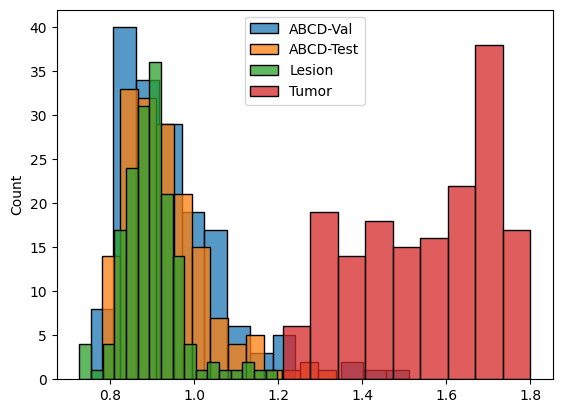

In [141]:
sns.histplot(X_val.flatten(), label="ABCD-Val")
sns.histplot(X_inlier.flatten(), label="ABCD-Test")
sns.histplot(X_lesion.flatten(), label="Lesion")
sns.histplot(X_tumor.flatten(), label="Tumor")
plt.legend()

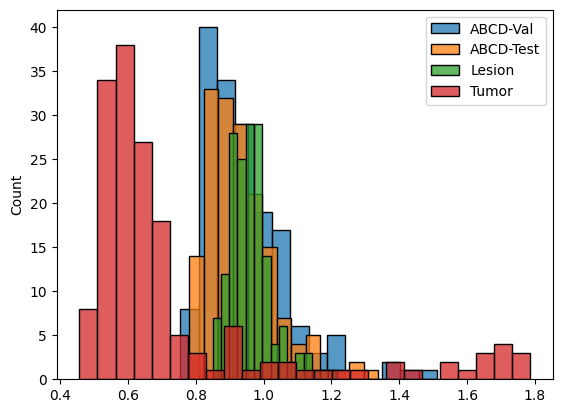

In [107]:
sns.histplot(X_val.flatten(), label="ABCD-Val")
sns.histplot(X_inlier.flatten(), label="ABCD-Test")
sns.histplot(X_lesion.flatten(), label="Lesion")
sns.histplot(X_tumor.flatten(), label="Tumor")
plt.legend()

Test vs Lesion
----------------
ROC-AUC: 39.9192
PR-AUC (In/Out): 41.4249 / 45.1620
FPR (95% TPR): 93.33%
Detection Error: 49.39%
FPR (99% TPR): 100.00%
----------------
Test vs Tumor
----------------
ROC-AUC: 99.8641
PR-AUC (In/Out): 99.8582 / 99.8758
FPR (95% TPR): 0.61%
Detection Error: 1.21%
FPR (99% TPR): 1.21%


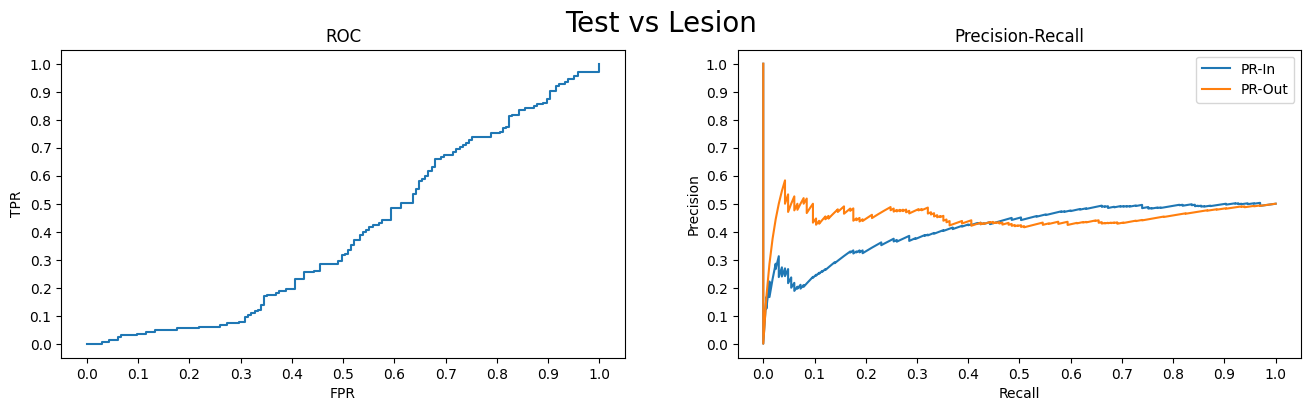

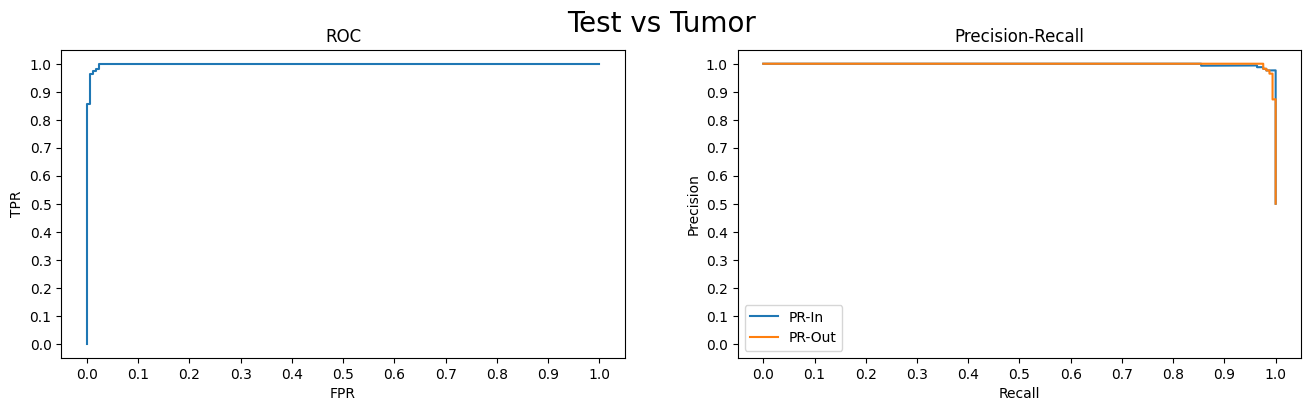

In [142]:
_=ood_metrics(X_inlier, X_lesion, plot=True, verbose=True, names=["Test", "Lesion"])
print("----------------")
_=ood_metrics(X_inlier, X_tumor, plot=True, verbose=True, names=["Test", "Tumor"])

Inlier vs Outlier
----------------
ROC-AUC: 57.0248
PR-AUC (In/Out): 54.1211 / 57.0375
FPR (95% TPR): 90.30%
Detection Error: 42.42%
FPR (99% TPR): 95.76%


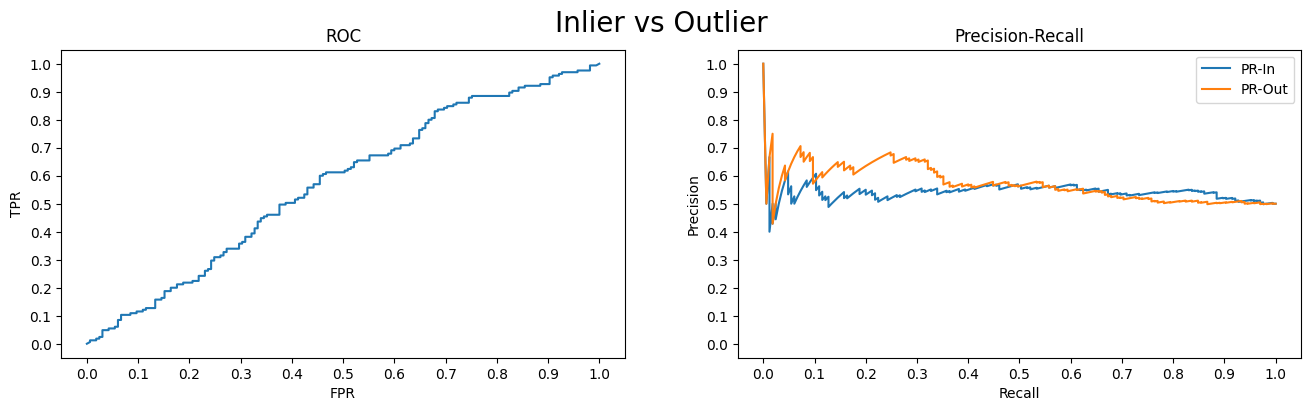

In [96]:
from sade.ood_detection_helper import ood_metrics

inlier_scores = (X_inlier - X_inlier.min(axis=0)) / (X_inlier.max(axis=0) -  X_inlier.min(axis=0))
ood_scores = (X_ood - X_ood.min(axis=0)) / (X_ood.max(axis=0) -  X_ood.min(axis=0))
_=ood_metrics(inlier_scores, ood_scores, plot=True, verbose=True)

In [99]:
from sade.ood_detection_helper import auxiliary_model_analysis

results = auxiliary_model_analysis(
    X_val[:, None],
    X_inlier[:, None],
    [X_ood[:,None]],
    components_range=range(3, 6, 1),
    labels=["Train", "Inlier", "OOD"],
    verbose=0
)

In [100]:
results['GMM']['metrics']

,ap,de,fpr_tpr95,fpr_tpr99,pr_auc_in,pr_auc_out,roc_auc,true_tpr95
OOD,50.528366,42.424242,91.515152,96.363636,50.117541,55.833851,54.820937,93.333333


In [101]:
results['KD Tree']['metrics']

,ap,de,fpr_tpr95,fpr_tpr99,pr_auc_in,pr_auc_out,roc_auc,true_tpr95
OOD,47.960484,47.575758,92.727273,94.545455,47.550564,51.362237,49.726354,93.333333


In [117]:
error_scores['abcd_tumor'].shape

(165, 96, 112, 80)

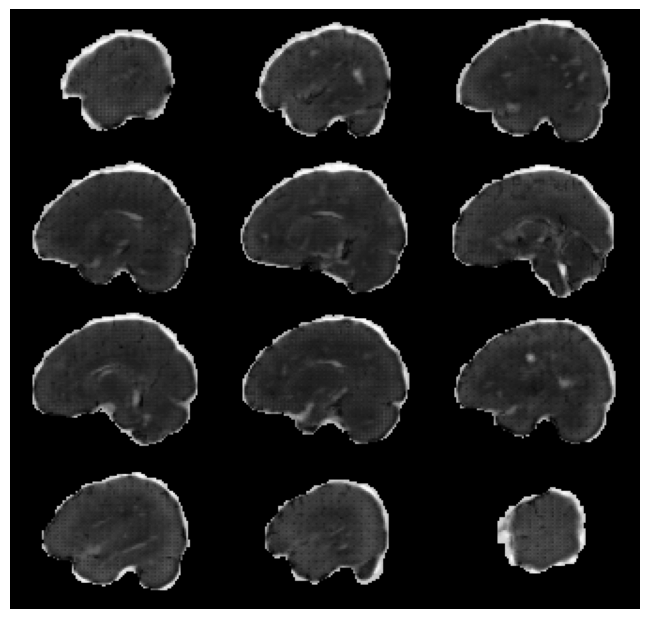

In [137]:
import ants

x_img = ants.from_numpy(error_scores['abcd_tumor'][0])
x_img.plot()

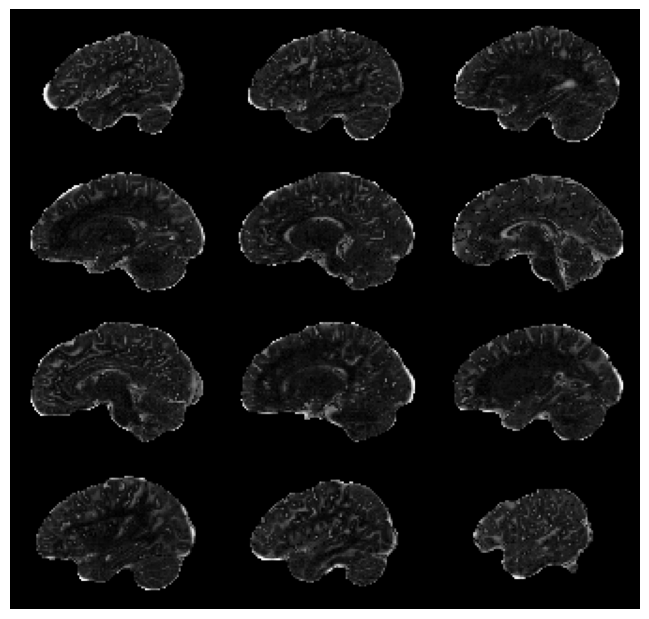

In [138]:
x_img = ants.from_numpy(error_scores['abcd-val'][0])
x_img.plot()